# Handling Missing Data

This notebook contains the Python code for our session on how to handle missing data.  It uses an example data set of blood glucose, as read from a FreeStyle Libre blood glucose monitor.  This is real data!

We start using the usual Python suspects: Pandas, NumPy and matplotlib.

In [1]:
# for Kalman Smoothing use R and R objects
import rpy2.robjects as robjects
# import R packages
from rpy2.robjects.packages import importr
imputeTS = importr('imputeTS') 

kalman_StructTs = robjects.r['na.kalman']
kalman_auto_arima = robjects.r['na.kalman']

# for other imputation methods
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

# for KNN
from fancyimpute import KNN

Using TensorFlow backend.


Next we get a day's worth of insulin data.  Note that we reindexed this to use the minute of the day as the index.

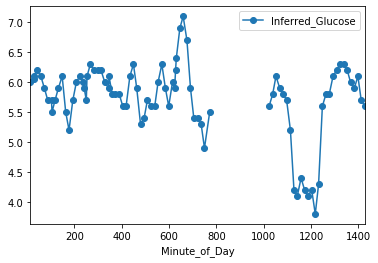

In [2]:
df = pd.read_excel('glucose.xlsx', index_col=0)
df.set_index('Minute_of_Day', inplace=True)
df.plot(style='o-')

Let's find the index entries of the missing data

In [3]:
missing_minutes = list(df[df['Inferred_Glucose'].isnull()].index)
missing_minutes

[787,
 802,
 817,
 832,
 847,
 862,
 877,
 892,
 907,
 922,
 937,
 952,
 967,
 982,
 997,
 1012]

Convenience function for plotting

In [4]:
def method_plot(df, cols):
    fig, ax = plt.subplots()
    if isinstance(cols, str):
        df[cols].plot(style='b--', ax=ax)
    else:
        for c in cols:
            df[c].plot(style='b--', ax=ax)        
    df['Inferred_Glucose'].plot(style='bo', ax=ax)

# Last-Observed Carry Forward (LOCF)

So easy it's build into Pandas' fillna() as method='ffill'

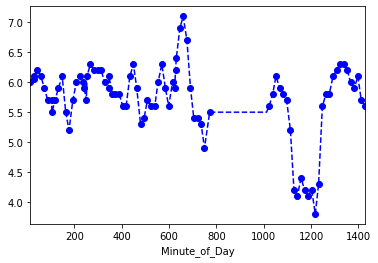

In [5]:
df['Glucose_LOCF'] = df['Inferred_Glucose'].fillna(method='ffill')
method_plot(df, 'Glucose_LOCF')

# Mean value

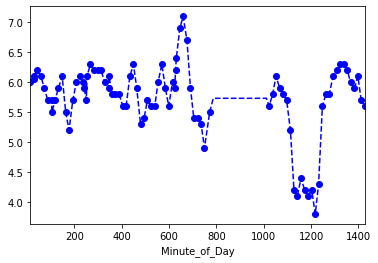

In [6]:
df['Glucose_Mean'] = df['Inferred_Glucose'].fillna(df['Inferred_Glucose'].mean())
method_plot(df, 'Glucose_Mean')

#  Nearest Neighbor

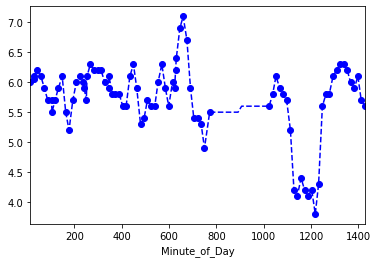

In [7]:
df['Glucose_nearest_neighbor'] = df['Inferred_Glucose'].interpolate(method='nearest')
method_plot(df, 'Glucose_nearest_neighbor')

# Linear Interpolation

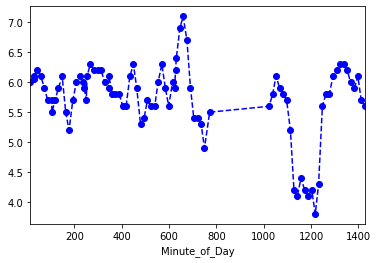

In [8]:
df['Glucose_linear_interpolation'] = df['Inferred_Glucose'].interpolate(method='linear')
method_plot(df, 'Glucose_linear_interpolation')

# Polynomial Interpolation

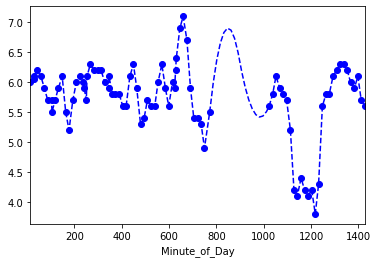

In [9]:
df['Glucose_poly_interpolation_2'] = df['Inferred_Glucose'].interpolate(method='polynomial', order=2)
method_plot(df, 'Glucose_poly_interpolation_2')

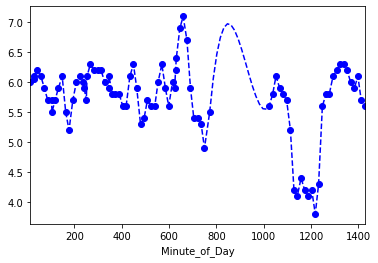

In [10]:
df['Glucose_poly_interpolation_3'] = df['Inferred_Glucose'].interpolate(method='polynomial', order=3)
method_plot(df, 'Glucose_poly_interpolation_3')

# Spline Interpolation

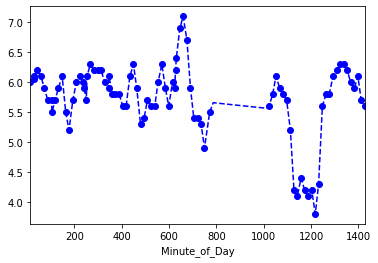

In [11]:
df['Glucose_spline_2'] = df['Inferred_Glucose'].interpolate(method='spline', order=2)
method_plot(df, 'Glucose_spline_2')

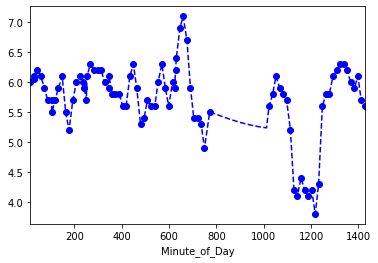

In [12]:
df['Glucose_spline_3'] = df['Inferred_Glucose'].interpolate(method='spline', order=3)
method_plot(df, 'Glucose_spline_3')

# Moving Average Imputation

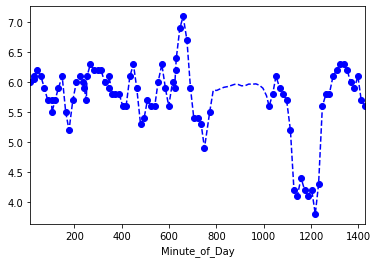

In [13]:
df['Glucose_moving_average']=df.loc[:, ['Inferred_Glucose']].assign(RollingMean=df['Inferred_Glucose'].fillna(df['Inferred_Glucose'].rolling(24,min_periods=1,).mean()))['RollingMean']
method_plot(df, 'Glucose_moving_average')

# Kalman Smoothing Imputation

In [14]:
# prepare input values for R 
this_value = np.ndarray.tolist(df['Inferred_Glucose'].values)
this_value = robjects.FloatVector(this_value)

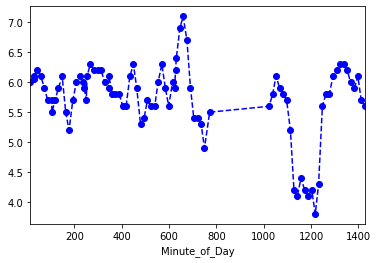

In [15]:
df['Glucose_kalman'] = kalman_StructTs(this_value, model = "StructTS")
method_plot(df, 'Glucose_kalman')

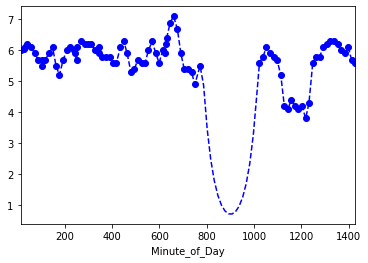

In [16]:
df['Glucose_kalman_arima']  = kalman_StructTs(this_value, model = "auto.arima")
method_plot(df, 'Glucose_kalman_arima')

# KNN imputation

Imputing row 1/102 with 0 missing, elapsed time: 0.005
Imputing row 101/102 with 0 missing, elapsed time: 0.007


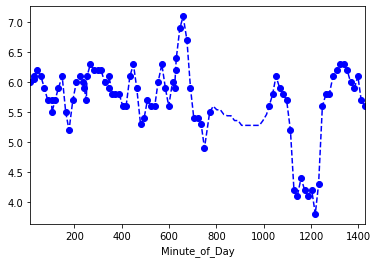

In [17]:
knn_impute = KNN(k = 5).fit_transform(df)
df['Glucose_KNN']=knn_impute[:, 0]
method_plot(df, 'Glucose_KNN')